# Twitter Classification and Analysis With Logistic Regression 
## Author: Robert McCormick

### Import necessary packages:

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
%matplotlib inline
import time
import warnings
warnings.filterwarnings('ignore')

/Users/robertmccormick/anaconda3/envs/ml/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robertmccormick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Visualization Helper Functions:

In [2]:
def create_count_dict(df_name):
    """
    Created dictionary from dataframe where tokens are keys and values are counts.
    Returns three dictionarys word, mention, and hashtag.

    """
    word_dict = {}
    at_dict = {}
    hash_dict = {}

    for index, row in df_name.items():
        for word in row:
            if word[0] == '#':
                if word not in hash_dict:
                    hash_dict[word] = 1
                else:
                    hash_dict[word] += 1
            elif word[0] == '@':
                if word not in at_dict:
                    at_dict[word] = 1
                else:
                    at_dict[word] += 1
            else:
                if word not in word_dict:
                    word_dict[word] = 1
                else:
                    word_dict[word] += 1
    return word_dict, at_dict, hash_dict

def plot_counts (feature_dict, name):
    """
    Plots the key and counts from dictionary
    """
    feature_dict
    sorted_dict = sorted(feature_dict.items(), key=lambda x: x[1], reverse=True)
    top_100 = sorted_dict[:100]
    top_100_words = [item[0] for item in top_100]
    top_100_count = [item[1] for item in top_100]


    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    fig.savefig('test2png.png', dpi=100)

    plt.bar(top_100_words, top_100_count)
    plt.xticks(rotation = 90)
    plt.xlabel(name)
    plt.ylabel('Count')
    plt.title('Top 100 ' + name)
    plt.show()

def wourdcloud_plot (feature_dict):
    """
    Plots wordcloud from the key and counts from dictionary
    """
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    min_font_size = 10).generate_from_frequencies(frequencies = feature_dict)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()


### Sentament Over Time Analysis Helper Functions:

In [3]:
def create_flag(df_name,search_word = None): 
    """
    Creats a indicator column in data set if a token is in a tweet
    takes in Tokenized_Texts column returns dataframe with new column
    
    """


    if search_word is None:
        return df_name
    for index, row in df_name.loc[:,'Tokenized_Text'].items():

        if search_word in row:

            df_name.loc[index,'Flag'] = 1
        else: 
            df_name.loc[index,'Flag'] = 0
    return df_name

def create_ratio(df):
    """
    This functions subsets inputted dataframe and groups data by year andby quater. 
    Then it calculates the ratio of positive tweets over all tweets that that token appears in per group.

    """
    #classificatoin from 1 to 0 and 5 to 1 
    df.loc[(df.loc[:,'Classification'] == 1), 'Classification'] = 0
    df.loc[(df.loc[:,'Classification'] == 5), 'Classification'] = 1

    #change to date time and make year and quarter columns
    df.loc[:,'Date'] = pd.to_datetime(df.loc[:,'Date'], format='%Y-%m-%d')
    df.loc[:,'Year'] = df.loc[:,'Date'].dt.year
    df.loc[:,'Quarter'] = df.loc[:,'Date'].dt.quarter

    #get count and sum of classification
    if len(df.columns) == 7:
        ratio = df.groupby(['Year','Quarter'], as_index=False).agg({'Classification':['count','sum']}).sort_values(['Year', 'Quarter'])
    else:
        ratio = df.loc[(df.loc[:,'Flag'] ==1), :].groupby(['Year','Quarter'], as_index=False).agg({'Classification':['count','sum']}).sort_values(['Year', 'Quarter'])

    ratio.loc[:, 'Positive_Ratio'] = ratio.loc[:, ('Classification', 'sum')] / ratio.loc[:, ('Classification', 'count')]
    return ratio

def plot_ratio(df , search_word):
    """
    Plots data frame of Positive ratio per quarter and year
    """
    plt.figure(figsize=(10, 6))
    plt.plot(df['Year'].astype(str) + 'Q' + df['Quarter'].astype(str), df['Positive_Ratio'], marker='o')
    plt.xlabel('Year and Quarter')
    plt.ylabel('Positive Ratio')
    plt.title('Positive Ratio For '+ str(search_word) + ' by Year and Quarter')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()



def plot_word_ratio(df,search_word = None):
    """
    Combines helper functions 
    """
    copy = df.copy()
    flag = create_flag(copy,search_word)
    ratio = create_ratio(flag)
    if search_word is None:
        search_word = "All Tweets"
    plot_ratio(ratio , search_word)

def best_feature_comparison(dict1, dict2, num, title):
    """
    This function plots word frequency dictionary into bar graph
    """

    feature_dict_t = {}
    feature_dict_y = {}

    for word in dict2.keys():
        if word in dict1.keys() and dict2[word] > num and dict1[word] > num:
            feature_dict_y[word] =dict2[word]
            feature_dict_t[word] =dict1[word]
            
    # Extract word and count information
    words = list(feature_dict_t.keys())
    count_twitter = list(feature_dict_t.values())
    count_yelp = list(feature_dict_y.values())

    # Set the position of the bars
    bar_positions = range(len(words))

    # Set the width of the bars
    bar_width = 0.35

    # Increase the figure size
    plt.figure(figsize=(18.5, 10.5))

   
    plt.bar(bar_positions, count_twitter, width=bar_width, color='blue', label='Twitter Count')
    plt.bar([p + bar_width for p in bar_positions], count_yelp , width=bar_width, color='green', label='Yelp Count')


    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.title(title)
    plt.xticks([p + bar_width / 2 for p in bar_positions], words)
    plt.legend()

    plt.show()


### 1. Prep Yelp data for training. 

1.1 Load the dataset with a sample of 100,000 Yelp reviews for training

In [4]:
yelp_data = pd.read_json('/Users/robertmccormick/Downloads/yelp_dataset/yelp_academic_dataset_review.json', 
                         lines=True, chunksize=100_000)
for chunk in yelp_data:
    yelp_sample_unequal = chunk
    result = chunk.to_json(orient="records")
    with open("yelp_sample.json", "w") as f:
        json.dump(result, f)
    break

yelp_sample_unequal['length'] = yelp_sample_unequal['text'].apply(len)
yelp_sample_unequal['stars'] = yelp_sample_unequal['stars'].astype(float)


1.2 Creating a yelp training data set with an equal amount of reviews per star 

In [5]:
yelp_classify = yelp_sample_unequal.loc[:, ['stars', 'text']]

print()
print("Shape of the dataset:", yelp_classify.shape)

x_unequal = yelp_classify['text']
y_unequal = yelp_classify['stars']

unequal_count = y_unequal.value_counts()
min_count = unequal_count.min()
yelp_sample_equal = (yelp_sample_unequal.groupby('stars').apply(lambda x: x[:min_count]))
print(yelp_sample_equal['stars'].value_counts())





Shape of the dataset: (100000, 2)
1.0    7988
2.0    7988
3.0    7988
4.0    7988
5.0    7988
Name: stars, dtype: int64


1.3 Applying the selected hyperparameters '1_5_stars', 'unigram', 'equal' to the yelp training data

In [6]:
yelp_train = yelp_sample_equal[(yelp_sample_equal['stars']==1) | (yelp_sample_equal['stars']==5)]
x_train_df = yelp_train['text']
y_train_df = yelp_train['stars']

#vectorize yelp data to unigram sparce matrix for train data 
yelp_unigram_vocab = (CountVectorizer(ngram_range=(1,1), stop_words='english').fit(yelp_train.loc[:, 'text']))
x_train_df = yelp_unigram_vocab.transform(x_train_df)

#training words 
vocabulary = yelp_unigram_vocab.get_feature_names_out()

### odd symbols in yelp data 
print(vocabulary)

['00' '000' '0000' ... 'łl' '三杯鸡' '鮨飯']


### 2. Classify Twitter Data Using the Tuned Hyperpameters and Selected Logistic Regression Model 

2.1 loading in and process twitter data 

In [7]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import string
nltk.download('stopwords')
nltk.download('wordnet')
#Change output_file_path to the path on your machine
stop_words = set(stopwords.words('english'))
punctuations = string.punctuation

#adding new_punct 
new_punct = '...,—…,“•”’'
punctuations = punctuations + new_punct

#adding additional stop word 
new_stopwords = 'rt'
stop_words.add(new_stopwords)

#Change the path to the path on your machine
df = pd.read_csv('/Users/robertmccormick/Downloads/obamacare_19_23.csv')
tokenizer=TweetTokenizer()
df['Tokenized_Text'] = df['Text'].apply(tokenizer.tokenize)


def preprocessing_twts(tokens):
    '''
    '''
    tokens = [token.lower() for token in tokens]
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    # Remove punctuations
    tokens = [token for token in tokens if token not in punctuations]
    return tokens

df['Tokenized_Text'] = df['Tokenized_Text'].apply(preprocessing_twts)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robertmccormick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/robertmccormick/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
twitter_df = df.copy()
twitter_df


Id        Date  \
0      1641893127261945857  2023-03-31   
1      1641879286805155848  2023-03-31   
2      1641871341581131777  2023-03-31   
3      1641860778788569094  2023-03-31   
4      1641860772669128705  2023-03-31   
...                    ...         ...   
36719  1080303994751221762  2019-01-02   
36720  1080276264404033536  2019-01-02   
36721  1080160174332174336  2019-01-01   
36722  1080105315331383296  2019-01-01   
36723  1079972489453809664  2019-01-01   

                                                    Text  \
0      This affects nearly 168 million people on empl...   
1      OK so, insurance companies are being given the...   
2      Texas judge rules against free preventive care...   
3      Texas judge strikes down free HIV drugs, cance...   
4      Texas judge strikes down free HIV drugs, cance...   
...                                                  ...   
36719  In covering #healthcare &amp; #Obamacare (ACA)...   
36720  ICYMI: Judge: Obama healthcare law remains in ...   
36721  @realDonaldTrump There you go again...denying ...   
36722  @USAneedsTRUMP @SenSherrodBrown You agreed wit...   
36723  .. insured at the new year! I'm a single paren...   

                                          Tokenized_Text  
0      [affects, nearly, 168, million, people, employ...  
1      [ok, insurance, companies, given, ability, cov...  
2      [texas, judge, rules, free, preventive, care, ...  
3      [texas, judge, strikes, free, hiv, drugs, canc...  
4      [texas, judge, strikes, free, hiv, drugs, canc...  
...                                                  ...  
36719  [covering, #healthcare, #obamacare, aca, 2019,...  
36720  [icymi, judge, obama, healthcare, law, remains...  
36721  [@realdonaldtrump, go, denying, coverage, suff...  
36722  [@usaneedstrump, @sensherrodbrown, agreed, oba...  
36723  [insured, new, year, i'm, single, parent, worr...  

[36724 rows x 4 columns]

2.2 Extracting Twitte Text column for testing data 

In [9]:
twitter_test_df = twitter_df.loc[:, ['Text']]
print(twitter_test_df)

                                                    Text
0      This affects nearly 168 million people on empl...
1      OK so, insurance companies are being given the...
2      Texas judge rules against free preventive care...
3      Texas judge strikes down free HIV drugs, cance...
4      Texas judge strikes down free HIV drugs, cance...
...                                                  ...
36719  In covering #healthcare &amp; #Obamacare (ACA)...
36720  ICYMI: Judge: Obama healthcare law remains in ...
36721  @realDonaldTrump There you go again...denying ...
36722  @USAneedsTRUMP @SenSherrodBrown You agreed wit...
36723  .. insured at the new year! I'm a single paren...

[36724 rows x 1 columns]


2.3 Vectorizing Twitter Testing Data and Applying it to the Logistic Regression Model With selected hyperparameters from tuning stage. 

c = 10, li penalty,  and 1000 iteration (package default)

In [10]:

twitter_unigram_vocab = (CountVectorizer(ngram_range=(1,1), stop_words='english').fit(twitter_test_df.loc[:,'Text']))

twitter_test = twitter_unigram_vocab.transform(twitter_test_df.loc[:,'Text'])

#change to len(train_yelp_df) number of columns
twitter_test = twitter_test[:,:30110]


#apply to Log Reg 
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(C= 10, penalty='l1', solver='liblinear')

log.fit(x_train_df, y_train_df)
predmnb = log.predict(twitter_test)
predmnb

array([5., 1., 1., ..., 1., 5., 1.])

2.4 Adding Classification Predictions to Twitter Data Frame

In [11]:

prediction = pd.Series(predmnb)

twitter_df.loc[:,'Classification'] = prediction
print(twitter_df['Classification'].value_counts())
twitter_df

1.0    26854
5.0     9870
Name: Classification, dtype: int64


Id        Date  \
0      1641893127261945857  2023-03-31   
1      1641879286805155848  2023-03-31   
2      1641871341581131777  2023-03-31   
3      1641860778788569094  2023-03-31   
4      1641860772669128705  2023-03-31   
...                    ...         ...   
36719  1080303994751221762  2019-01-02   
36720  1080276264404033536  2019-01-02   
36721  1080160174332174336  2019-01-01   
36722  1080105315331383296  2019-01-01   
36723  1079972489453809664  2019-01-01   

                                                    Text  \
0      This affects nearly 168 million people on empl...   
1      OK so, insurance companies are being given the...   
2      Texas judge rules against free preventive care...   
3      Texas judge strikes down free HIV drugs, cance...   
4      Texas judge strikes down free HIV drugs, cance...   
...                                                  ...   
36719  In covering #healthcare &amp; #Obamacare (ACA)...   
36720  ICYMI: Judge: Obama healthcare law remains in ...   
36721  @realDonaldTrump There you go again...denying ...   
36722  @USAneedsTRUMP @SenSherrodBrown You agreed wit...   
36723  .. insured at the new year! I'm a single paren...   

                                          Tokenized_Text  Classification  
0      [affects, nearly, 168, million, people, employ...             5.0  
1      [ok, insurance, companies, given, ability, cov...             1.0  
2      [texas, judge, rules, free, preventive, care, ...             1.0  
3      [texas, judge, strikes, free, hiv, drugs, canc...             1.0  
4      [texas, judge, strikes, free, hiv, drugs, canc...             1.0  
...                                                  ...             ...  
36719  [covering, #healthcare, #obamacare, aca, 2019,...             1.0  
36720  [icymi, judge, obama, healthcare, law, remains...             1.0  
36721  [@realdonaldtrump, go, denying, coverage, suff...             1.0  
36722  [@usaneedstrump, @sensherrodbrown, agreed, oba...             5.0  
36723  [insured, new, year, i'm, single, parent, worr...             1.0  

[36724 rows x 5 columns]

### 3. Visualizing Results of Classified Data 

3.1 Here we are visualizing which features occur most frequenty in the positivly classified tweets.

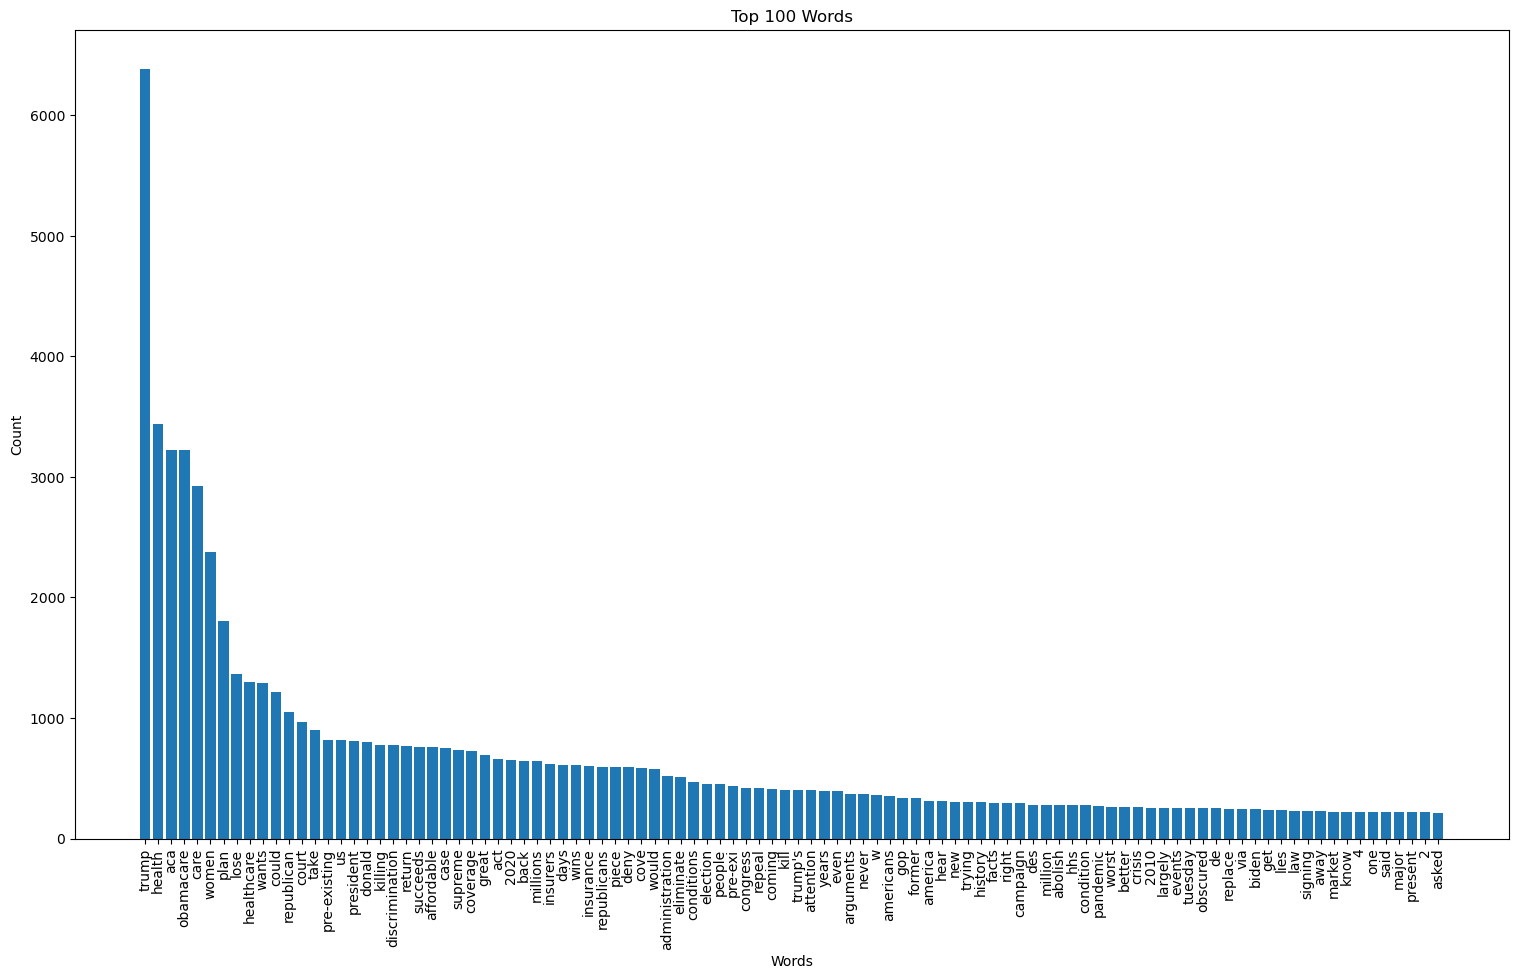

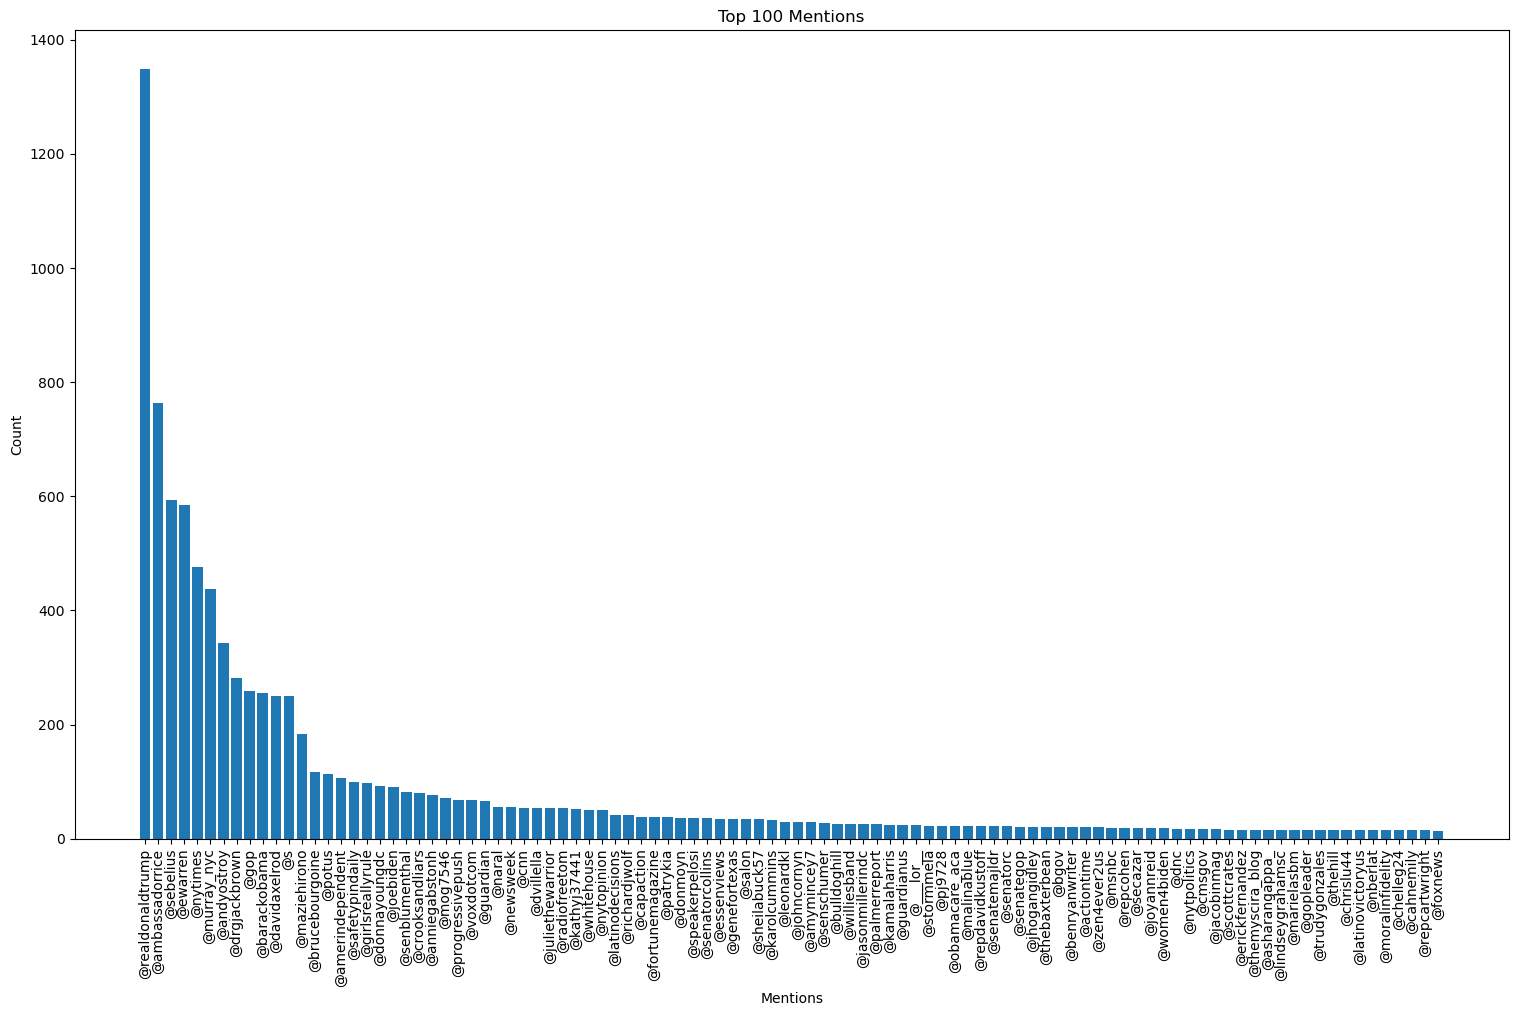

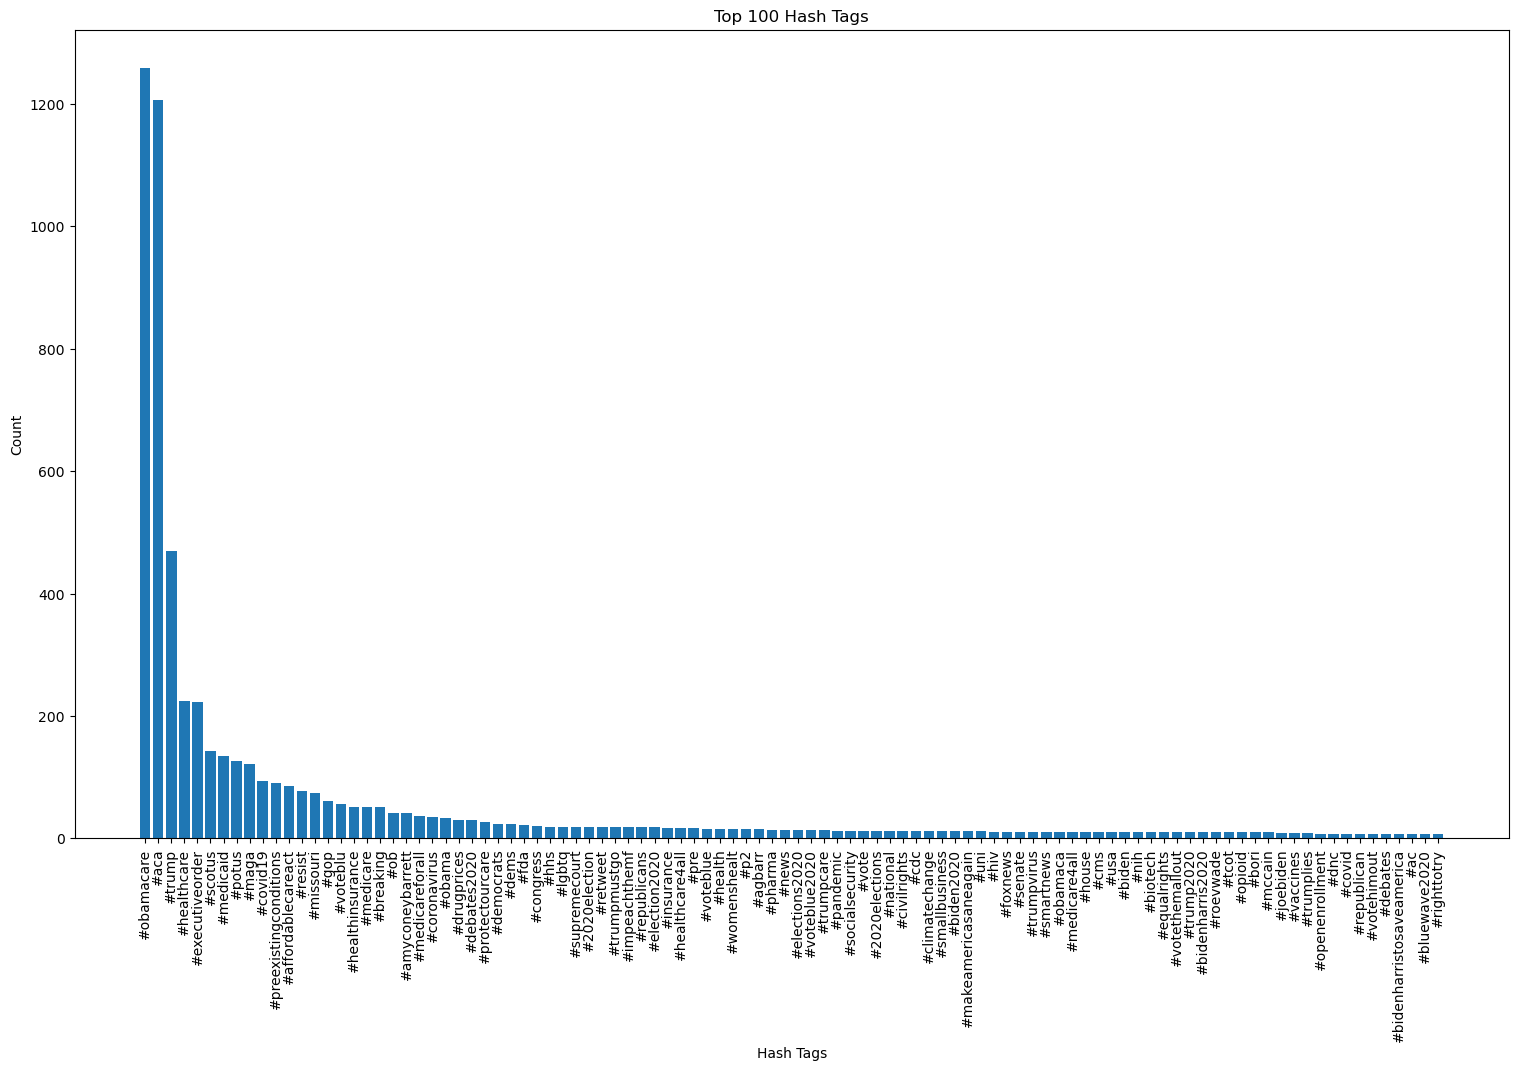

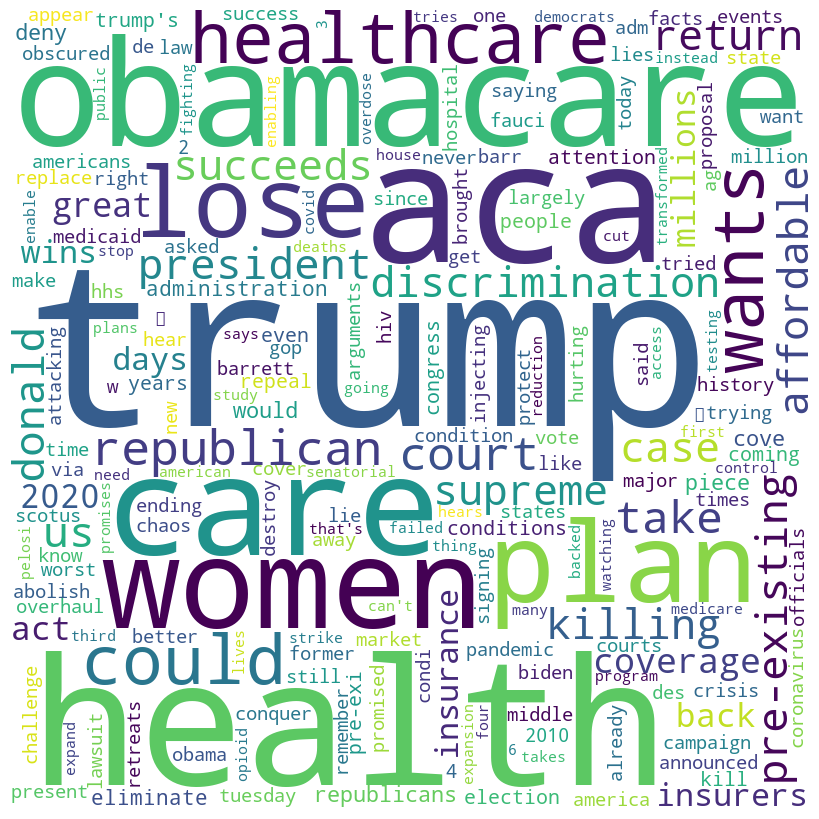

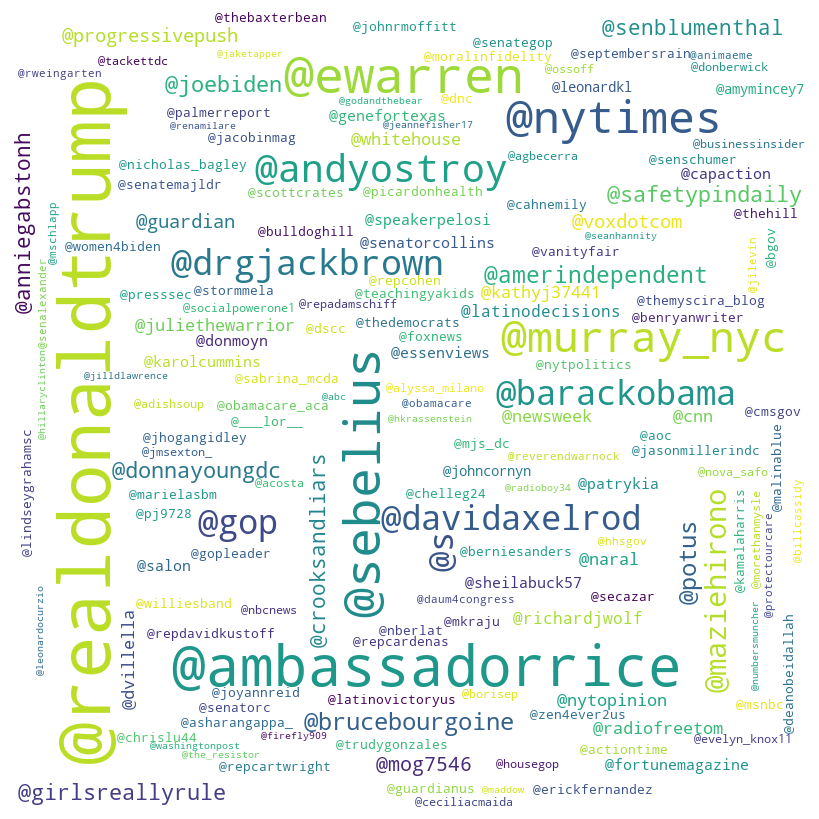

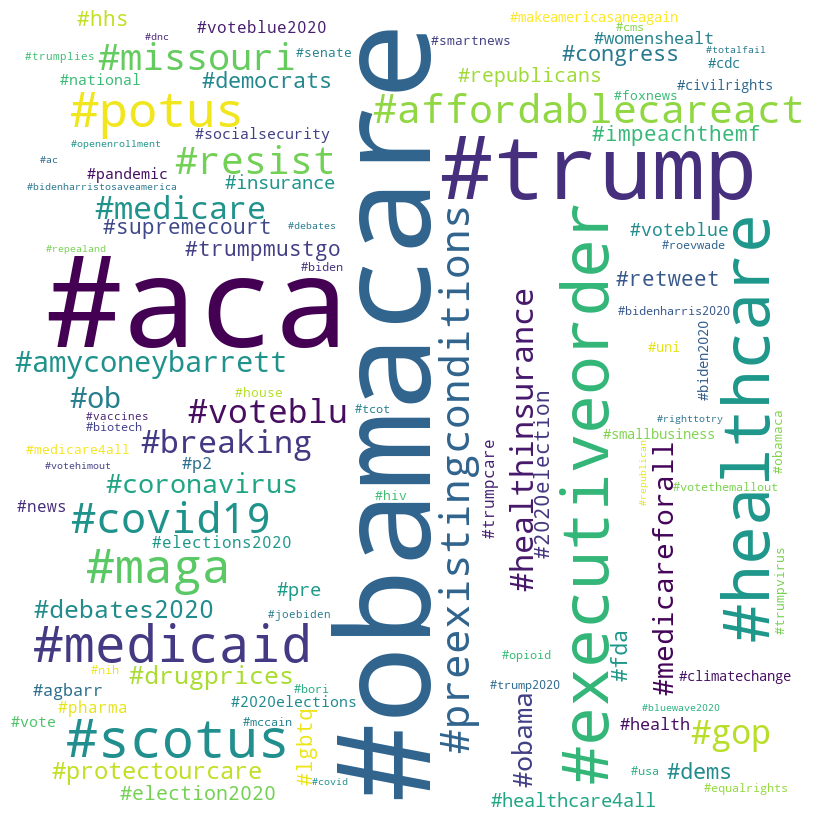

In [12]:

positive = twitter_df.loc[(twitter_df.loc[:,'Classification'] == 5),:]

word_dict_postive_twitter, at_dict_postive_twitter, hash_dict_postive_twitter = create_count_dict(positive.loc[:,'Tokenized_Text'])

plot_counts(word_dict_postive_twitter, 'Words')
plot_counts(at_dict_postive_twitter, 'Mentions')
plot_counts(hash_dict_postive_twitter, 'Hash Tags')

wourdcloud_plot (word_dict_postive_twitter)
wourdcloud_plot (at_dict_postive_twitter)
wourdcloud_plot (hash_dict_postive_twitter)

Here we can see the word 'trump' occurs far more than other features in positive classification. For meantions, '@realdonaldtrump' occurs most frequently. Lastly, the hashtags #obamacare and #aca occur most often in the postive classifications.

3.2 Creating Negative Tweet Data Frame and Visualizing results 

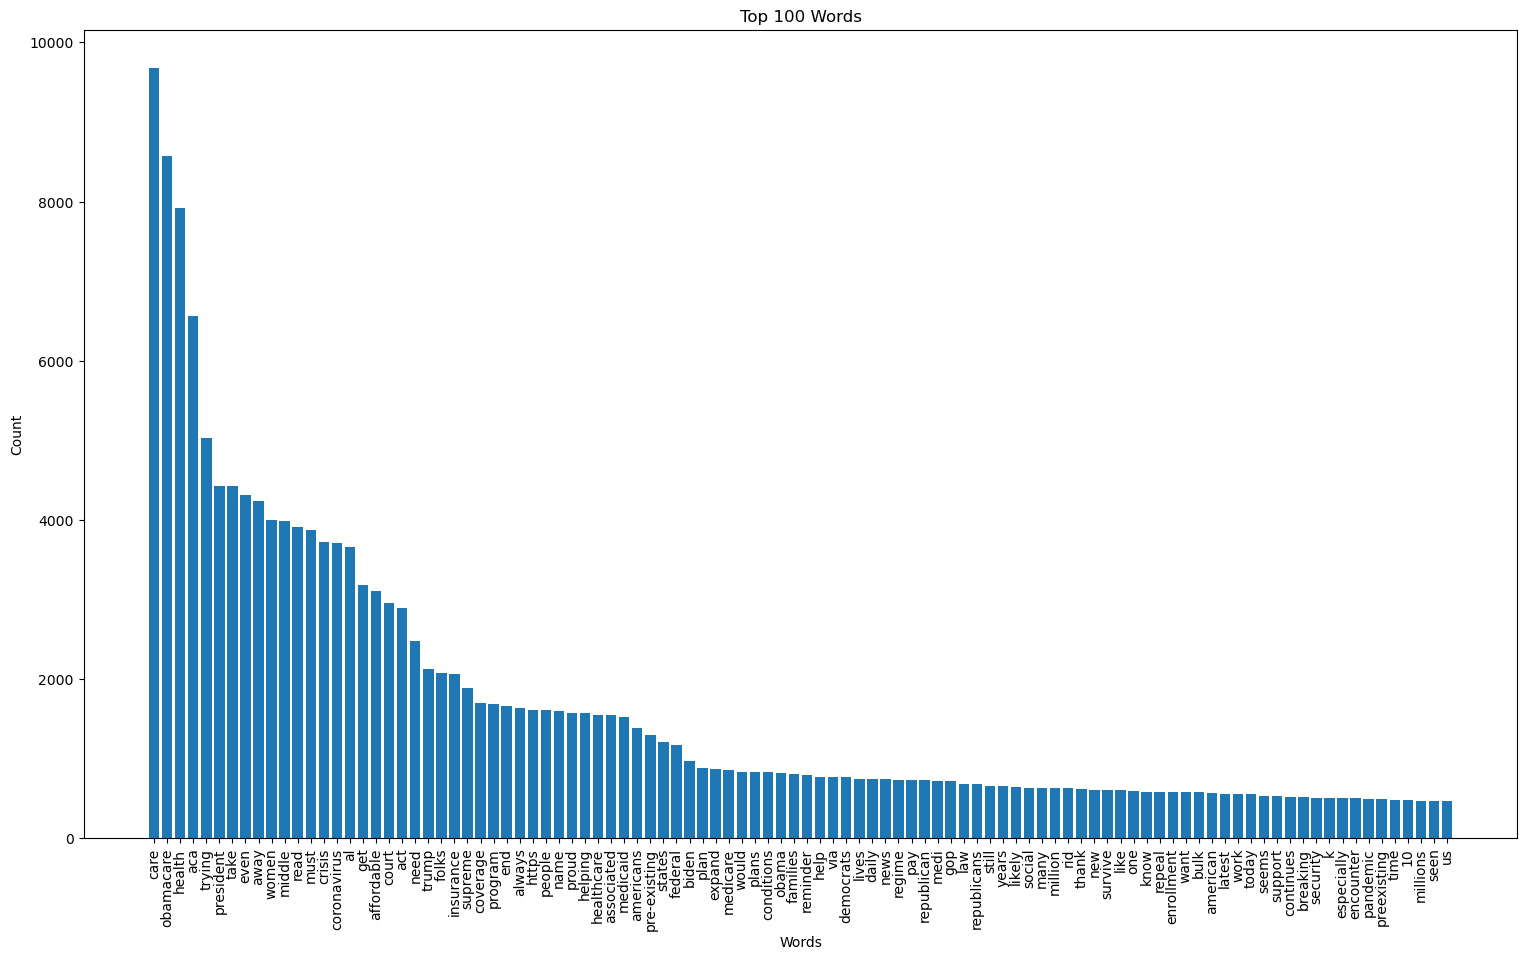

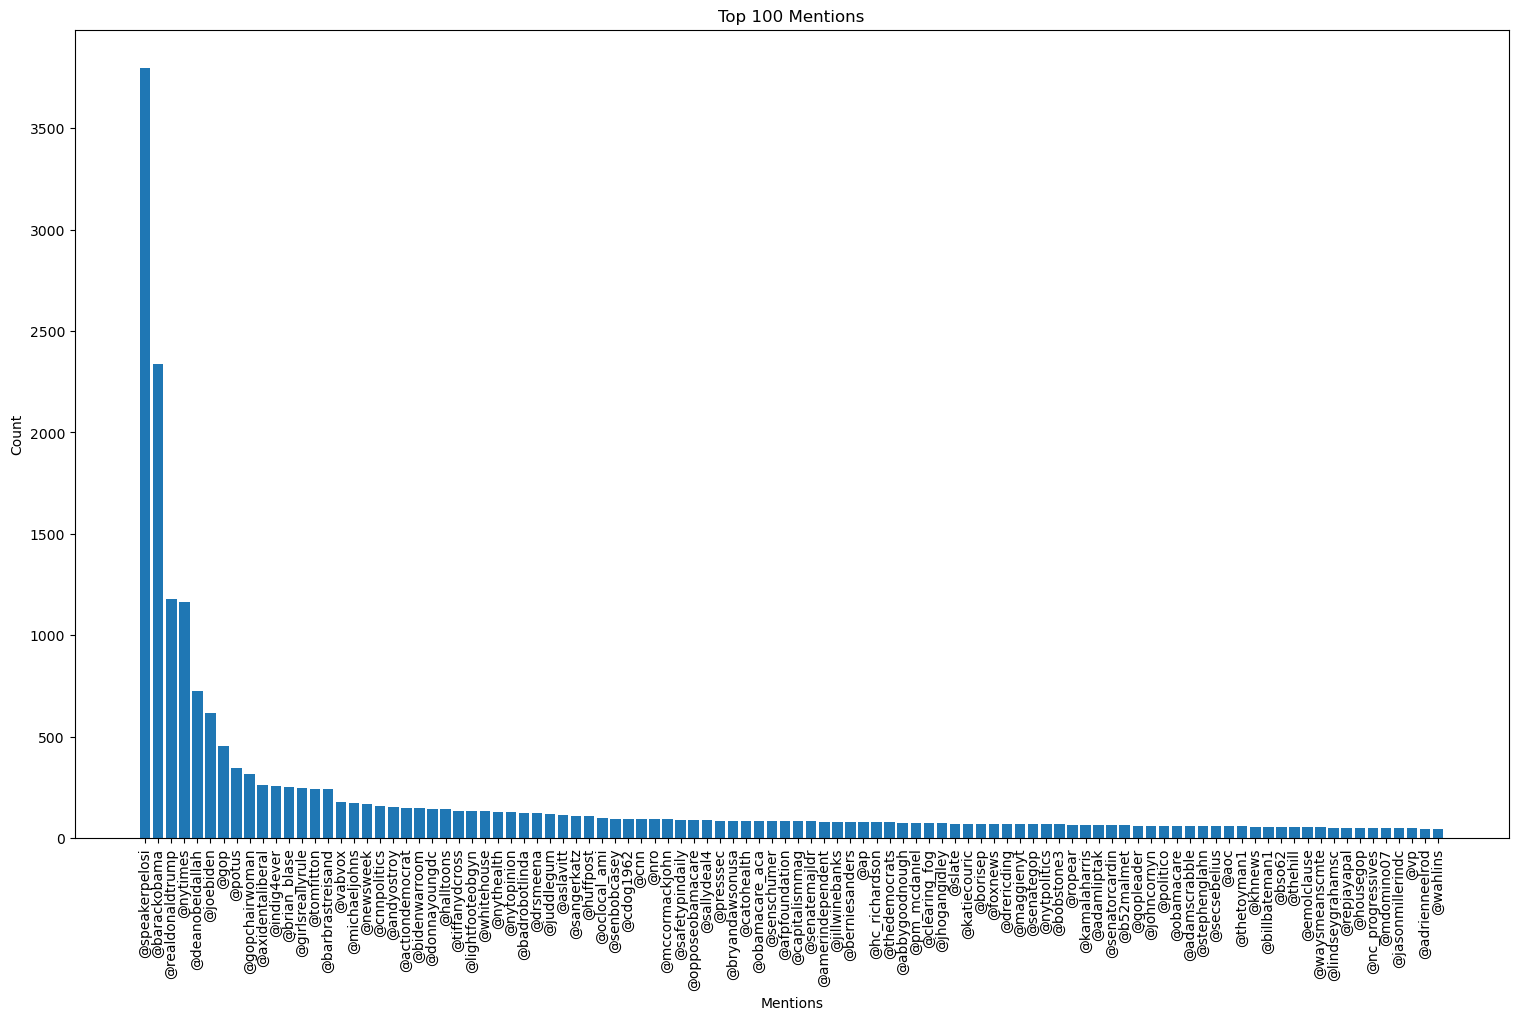

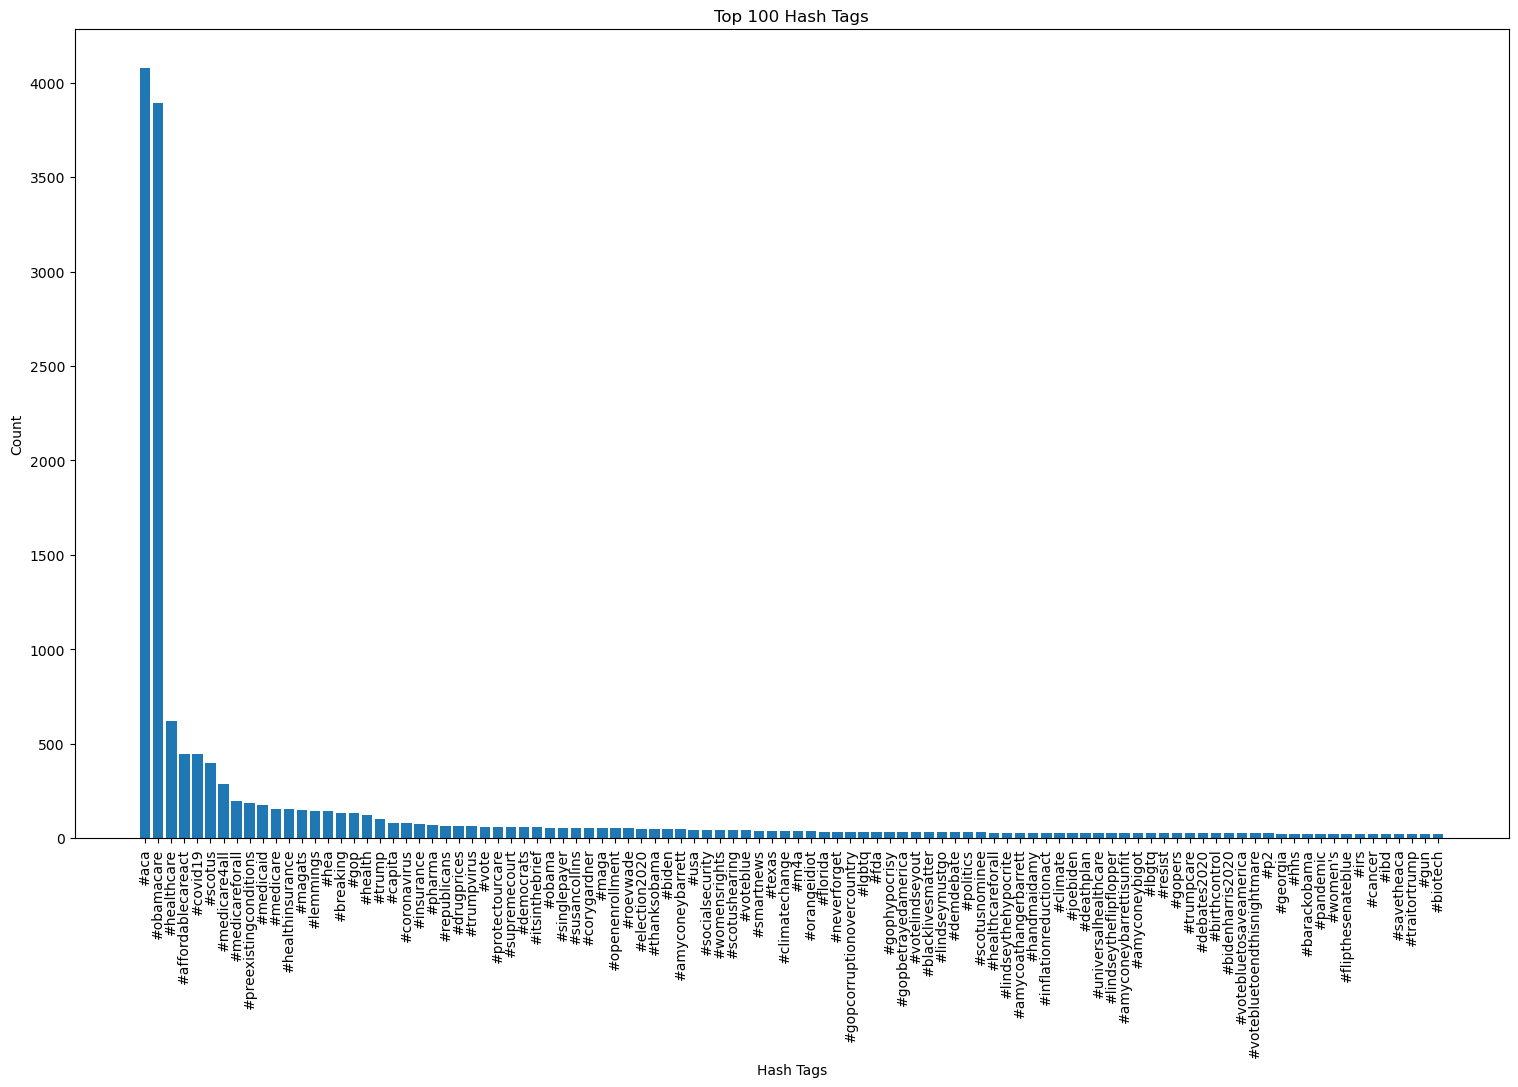

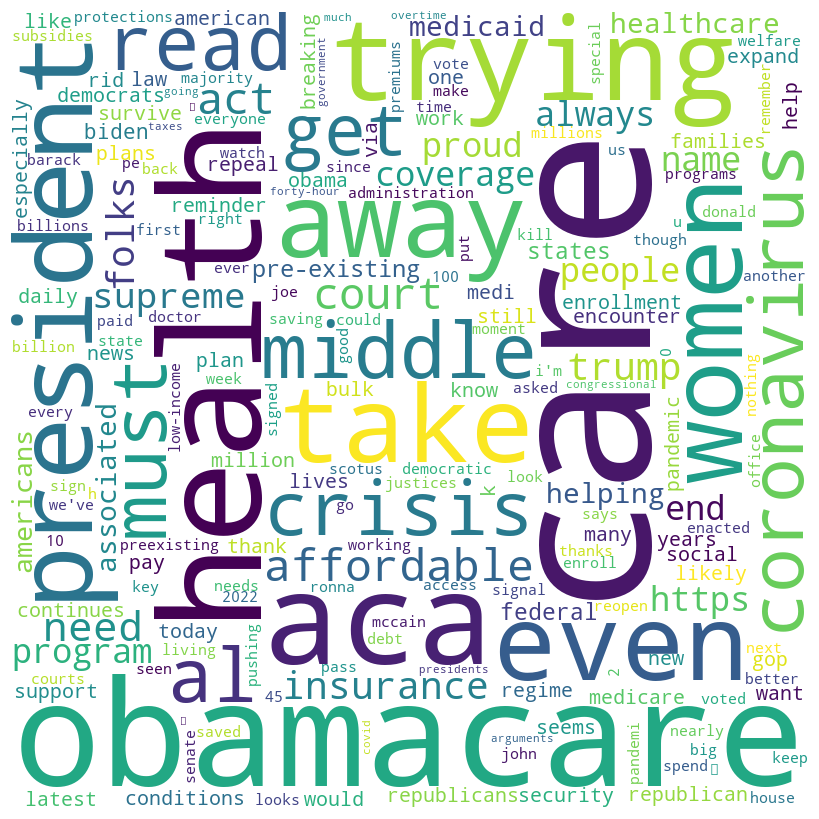

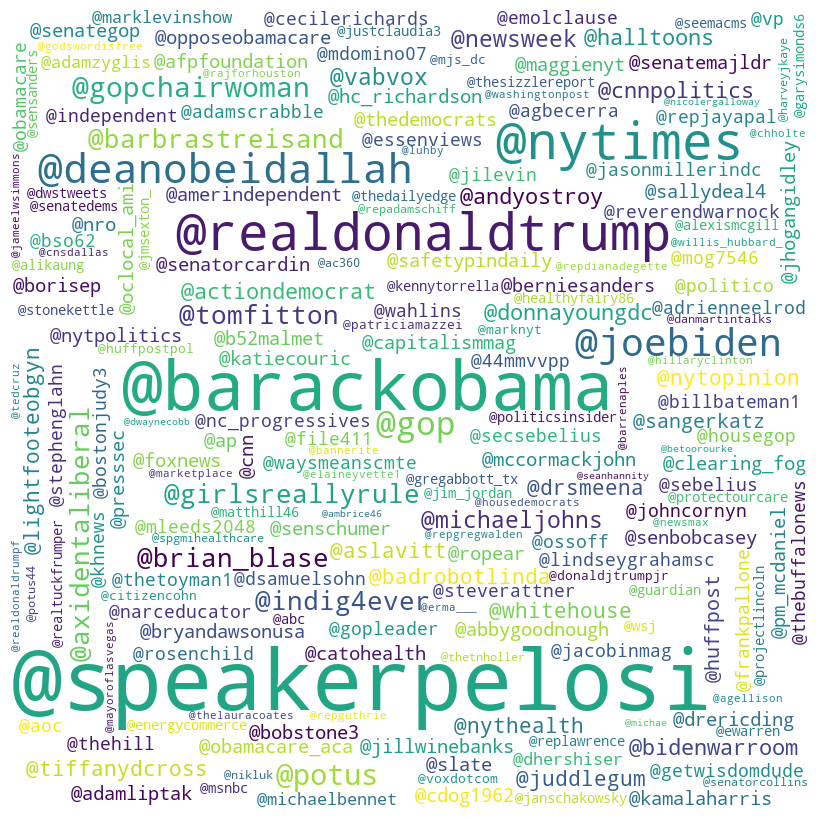

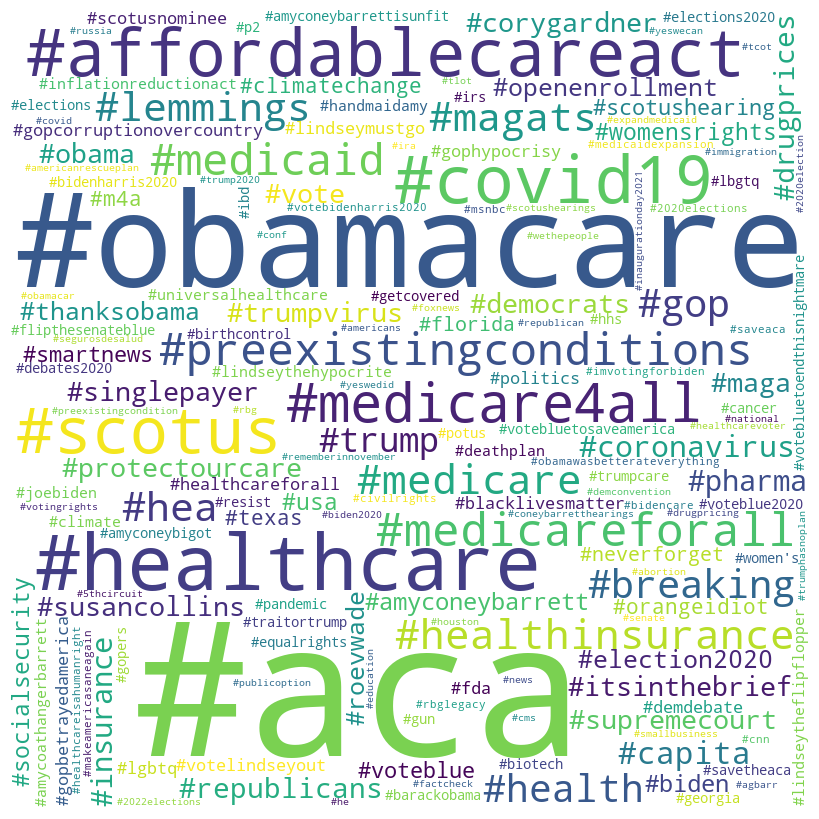

In [13]:

negative = twitter_df.loc[(twitter_df.loc[:,'Classification'] == 1),:]


word_dict_negative_twitter, at_dict_negative_twitter, hash_dict_negative_twitter = create_count_dict(negative.loc[:,'Tokenized_Text'])

plot_counts(word_dict_negative_twitter, 'Words')
plot_counts( at_dict_negative_twitter, 'Mentions')
plot_counts(hash_dict_negative_twitter, 'Hash Tags')

wourdcloud_plot (word_dict_negative_twitter)
wourdcloud_plot ( at_dict_negative_twitter)
wourdcloud_plot (hash_dict_negative_twitter)

The features that occure most frequently in the negative classification appears to be obama care for the word features, '@speakerpelosi' for the mentions, and #aca and #obamacare for the hastags.

### 4. This stage we are evaluating which features explain positive and negative sentiments over time?


To explore the best features that explain positive and negative sentiments we subsetted the yelp and twitter data into positive and negative dataframes. From there we created a dictionary for counts of each unique feature for the respective dataframes. To then evaluate which features explain positive sentiment we created a function that makes a new dictionary of words that occur in both data sets at a certain threshold and plotted the results. The reasoning behind this is that features or words that occur most frequently in the positive yelp data set would have the most influence on classifying what tweets were positive. Furthermore we wanted to see the overlapping words in both positive data sets to see which words or features had the most influence in classification. We then applied the same process to the corresponding negative data sets. 


4.1 This plot show the features that apear both in the Yelp and Twitter data that apear over 1000 times.

In [14]:

yelp_train['Tokenized_Text'] = yelp_train['text'].apply(tokenizer.tokenize)
yelp_train['Tokenized_Text'] = yelp_train['Tokenized_Text'].apply(preprocessing_twts)

yelp_postive = yelp_train.loc[(5.0),:]
yelp_negative = yelp_train.loc[(1.0),:]

yelp_word_dict, yelp_at_dict, yelp_hash_dict = create_count_dict(yelp_train.loc[:,'Tokenized_Text'])

word_dict_twitter, at_dict_twitter, hash_dict_twitter = create_count_dict(twitter_df.loc[:,'Tokenized_Text'])


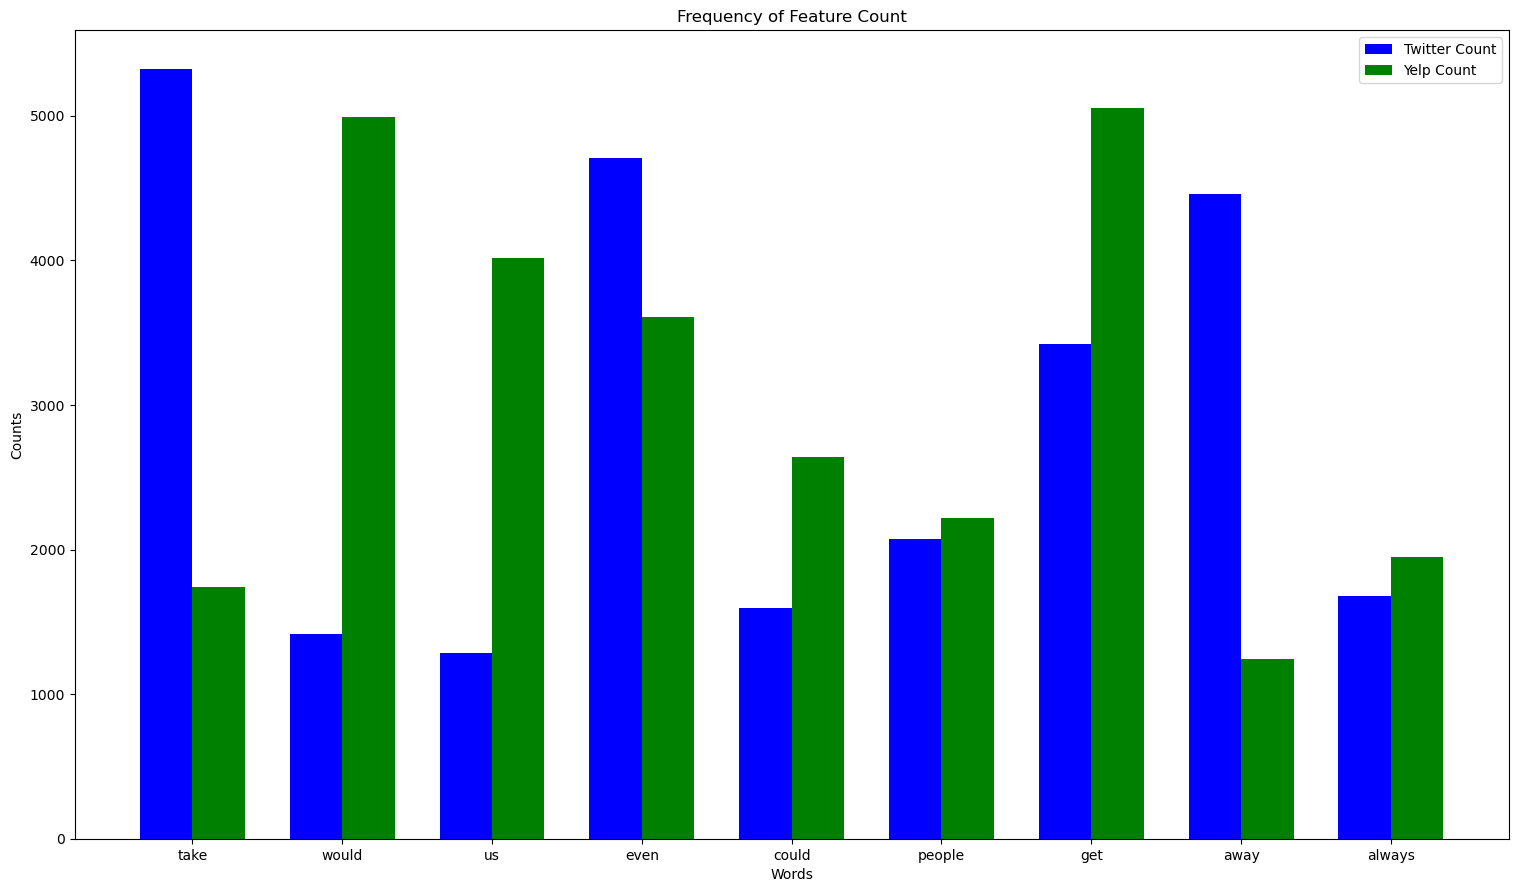

In [15]:
yelp_word_dict
word_dict_twitter
best_feature_comparison(word_dict_twitter,yelp_word_dict, 1000, 'Frequency of Feature Count')

4.2 This next plot shows the postive sentiment feature count for a threshold of 400 occurances 

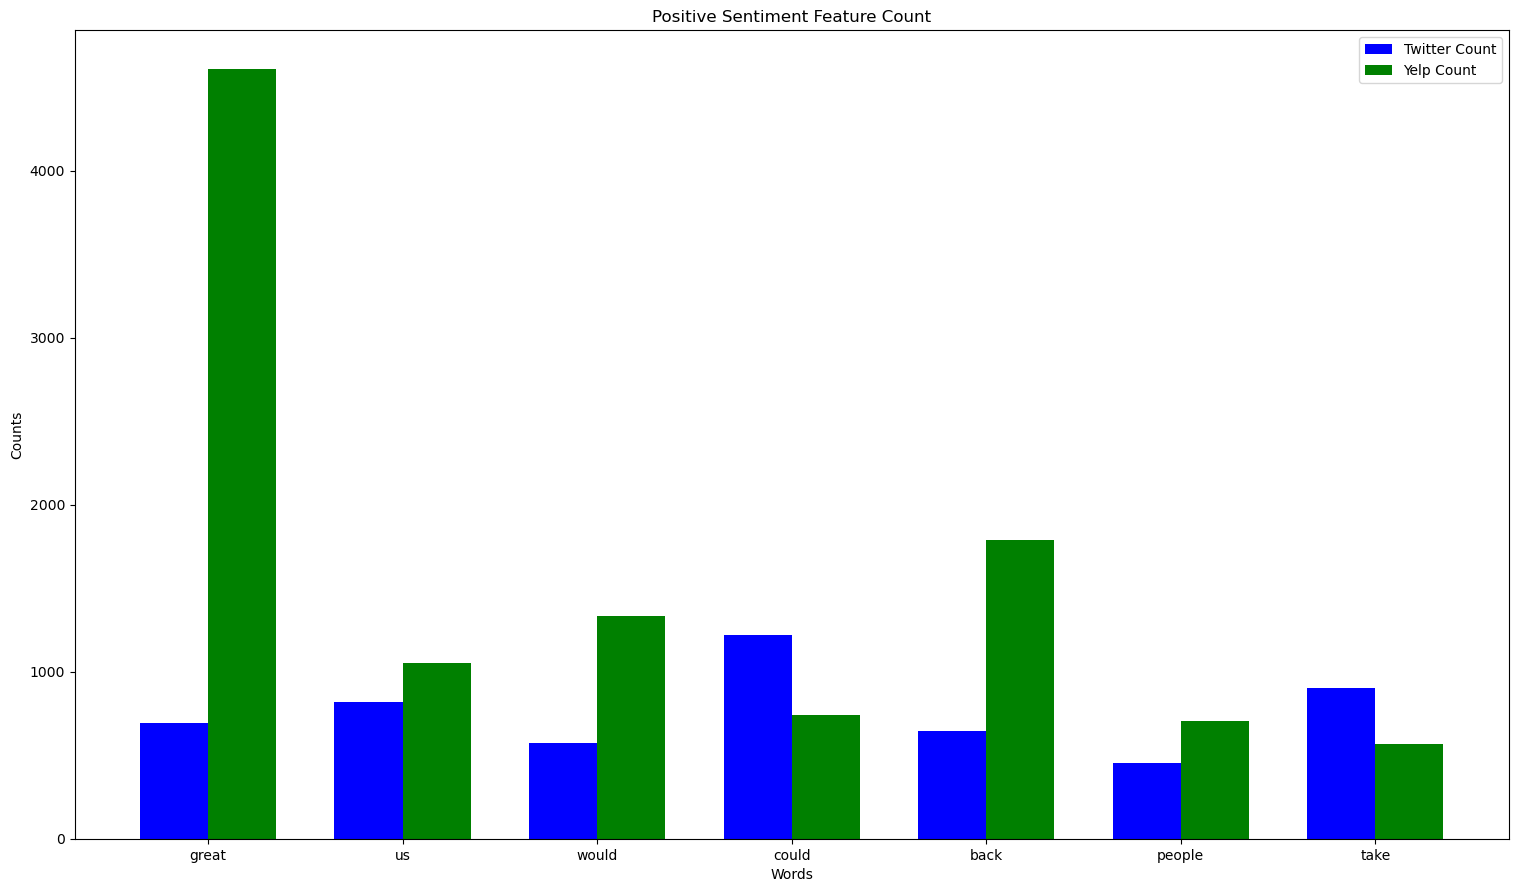

In [16]:

yelp_word_dict_postive, yelp_at_dict_postive, yelp_hash_dict_postive = create_count_dict(yelp_postive.loc[:,'Tokenized_Text'])
word_dict_postive_twitter

best_feature_comparison(word_dict_postive_twitter,yelp_word_dict_postive, 400, 'Positive Sentiment Feature Count')

4.3 This next plot shows the negative sentiment feature count for a threshold of 400 occurances 

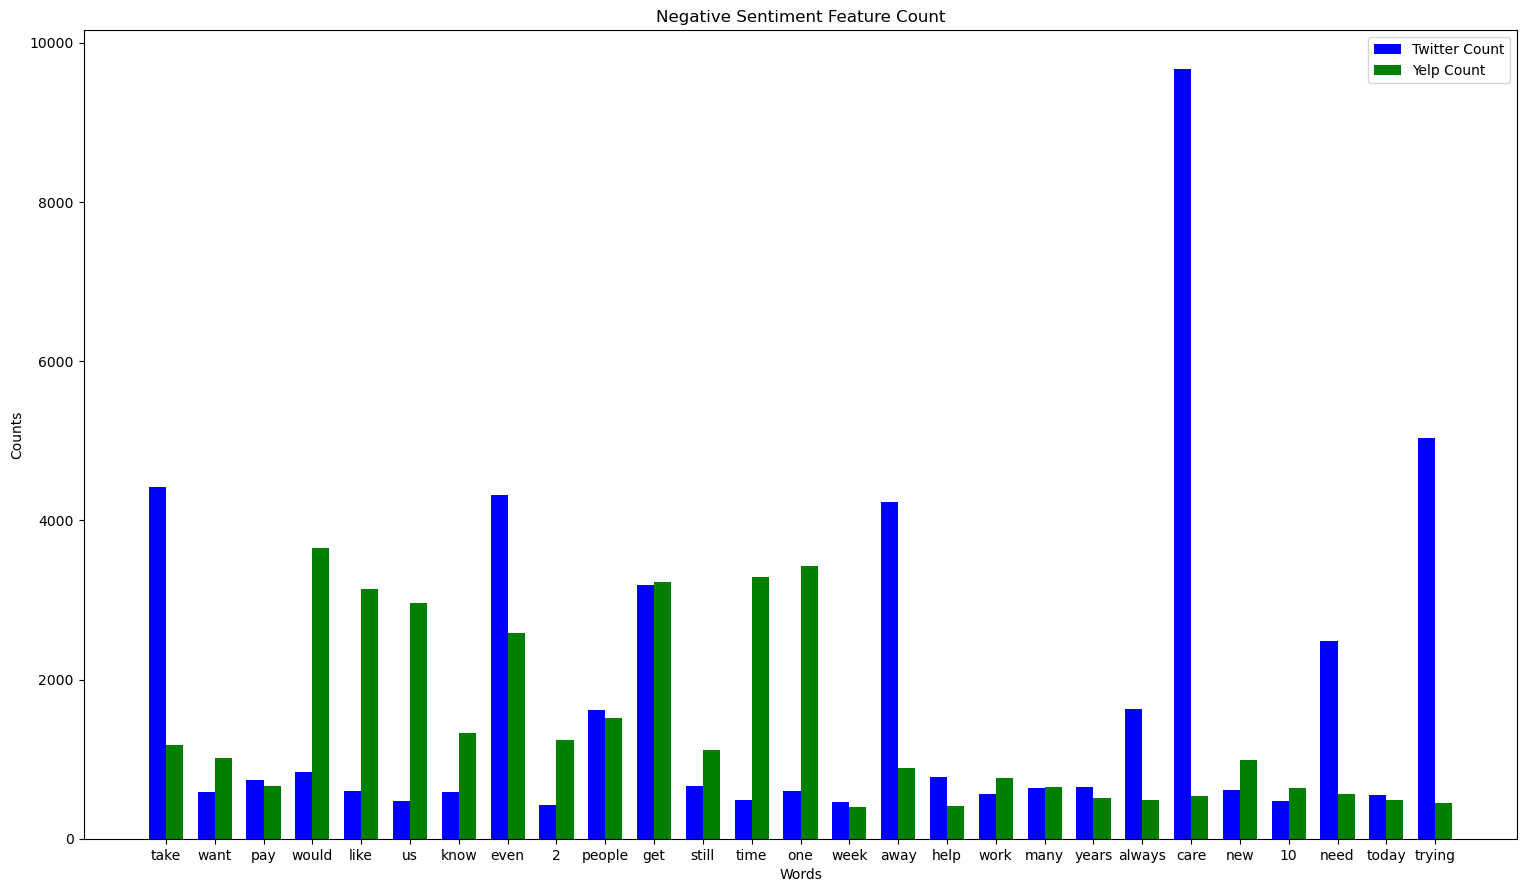

In [17]:
yelp_word_dict_negative, yelp_at_dict_negative, yelp_hash_dict_negative = create_count_dict(yelp_negative.loc[:,'Tokenized_Text'])
word_dict_negative_twitter

best_feature_comparison(word_dict_negative_twitter,yelp_word_dict_negative, 400, "Negative Sentiment Feature Count")

4.3 The next step is to evaluate how the sentiment of these features change over time. We approached this by selecting the features that seemed to have the most influence for positive sentiment based on the count thresholds. We then created a function that takes in the whole twitter dataframe including the positive and negative classifications that then subsetted the dataframe into only tweets containing that feature. Then calculated the ratio of positive tweets over all of the tweets for that feature per quarter per year. This allows us to see how the ratio changes over time. In addition, we applied this function to see overall sentiment over time, selected words, mentions, and hashtags. 

In the results we can see many overlapping words in both the positive and negative feature count plots like “take”, “people '', and “years' '. These we will consider a neutral since it appears in both datasets. We then selected the unique words from the positive plot like ‘great’ and ‘back” and for the negative sentiment we selected ‘away’ and ‘care’. These words ,except for great, do not have a positive or negative connotation on their own but they were selected based on uniqueness in the respective data set and more weight on occurrence in twitter data set. 


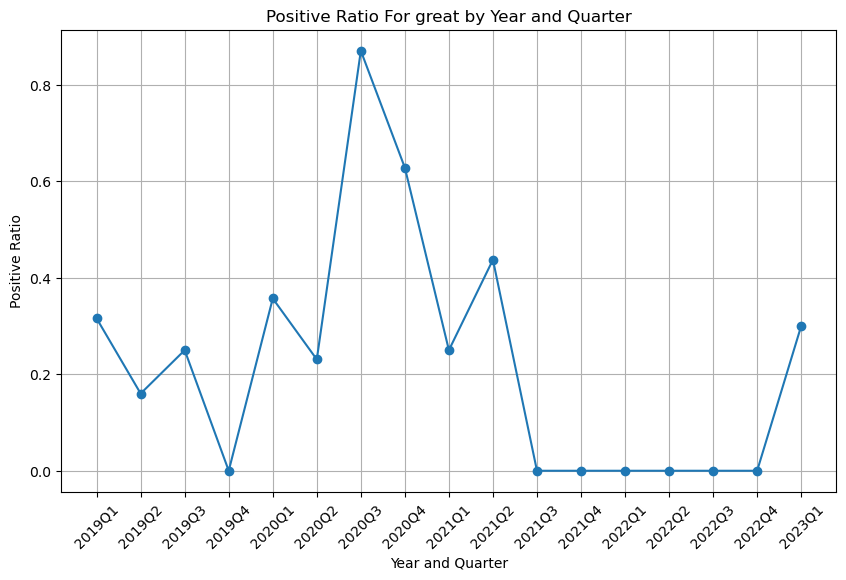

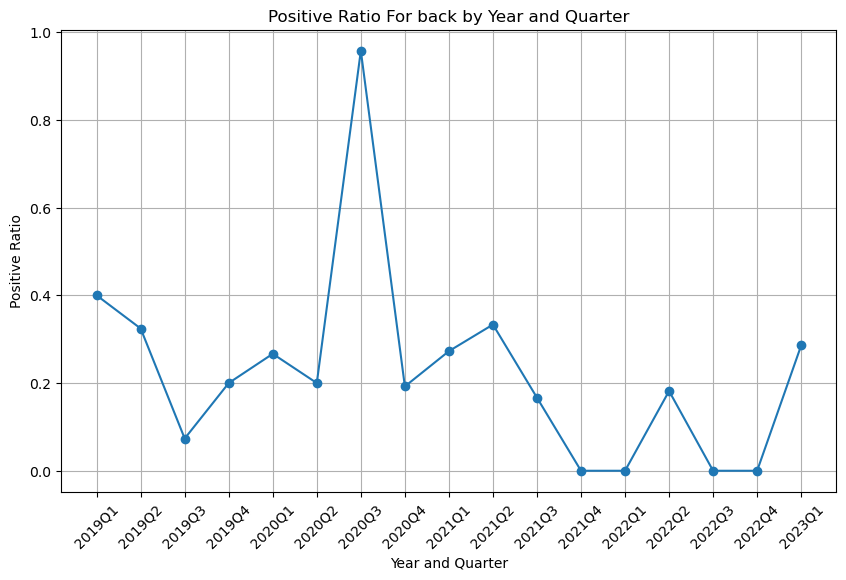

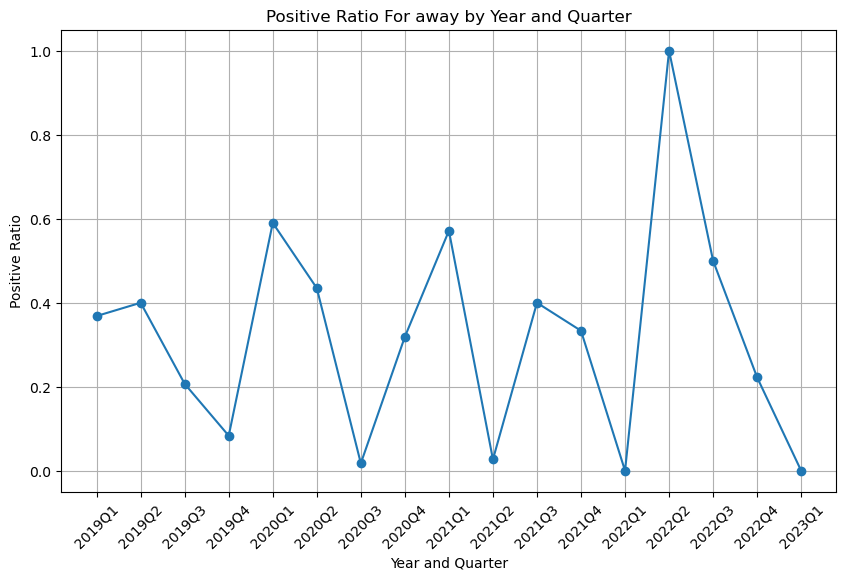

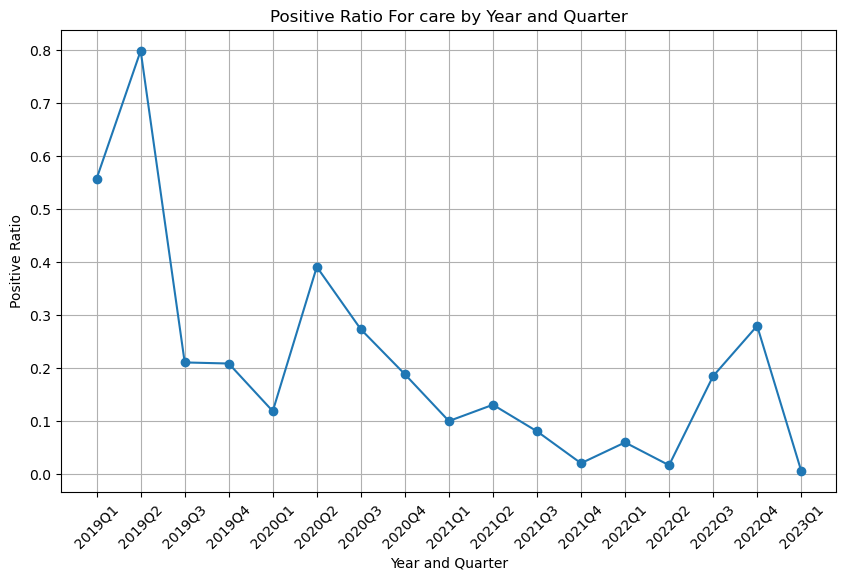

In [18]:

plot_word_ratio(twitter_df, 'great') 
plot_word_ratio(twitter_df, 'back') 
plot_word_ratio(twitter_df, 'away') 
plot_word_ratio(twitter_df, 'care') 


What we were hoping to see here is a consitently high ratio of more positive or less positve for the selected postive and negative features, respectively. What is potentially happening is that selecting a single feature does not determine the classification and it is the cummulation of all the features that determines the classification. Potentially selecting trigrams or bigrams as a hyperparameter could provide more consistency on what features determine positive and negative sentament over time.  

### 5.1 Final Results and Different Feature Exploration from Twitter Data Classification

5.1 Here we plot overall sentiment over time and explore the outliers and overlap in the positive and negative twitter feature exploration. 

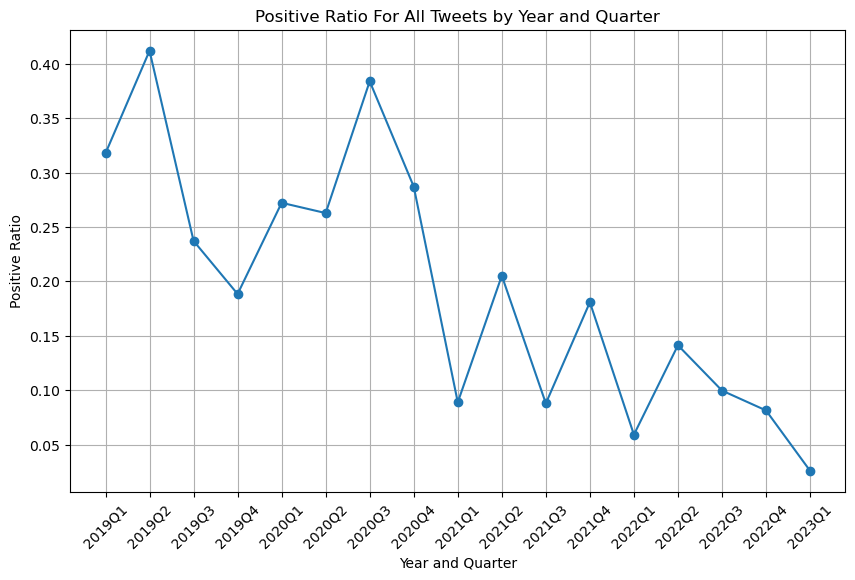

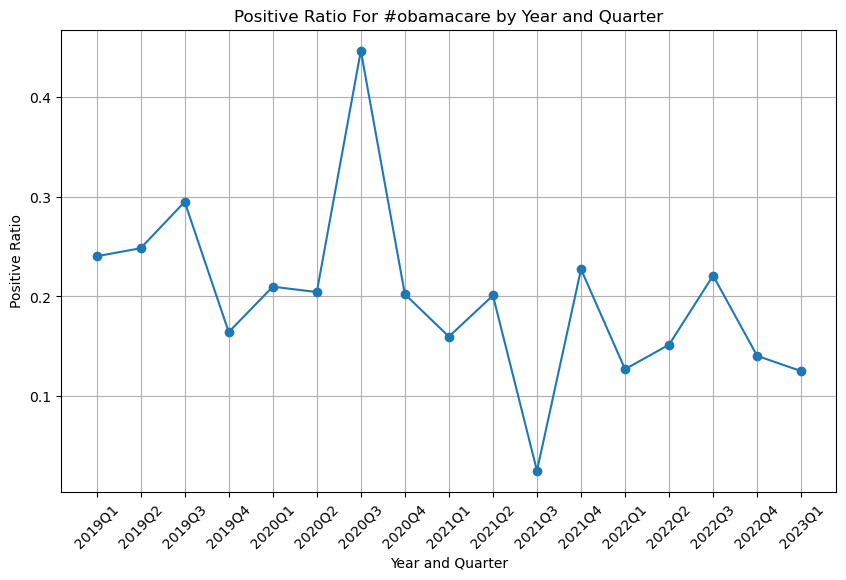

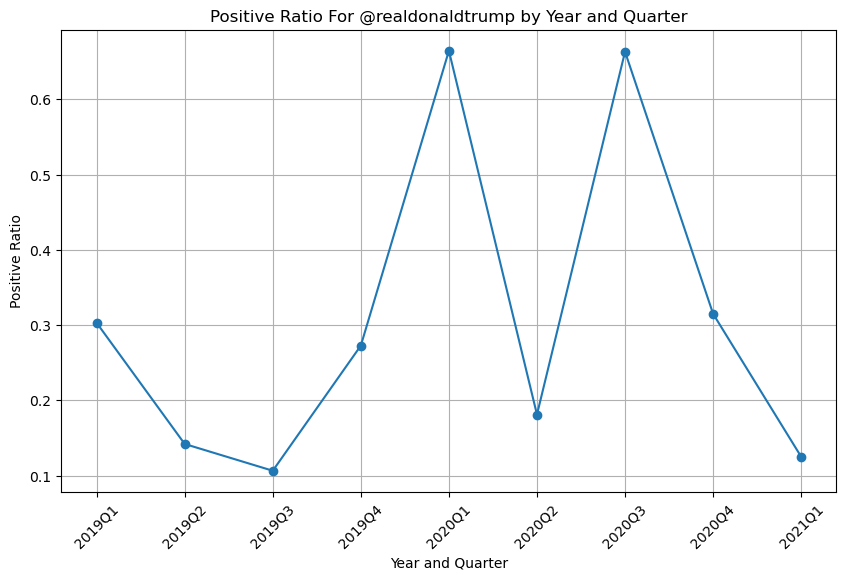

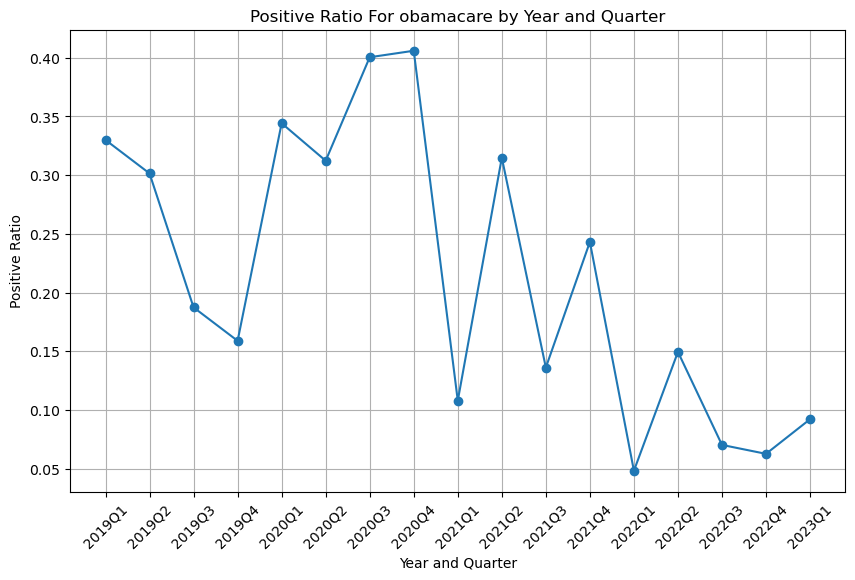

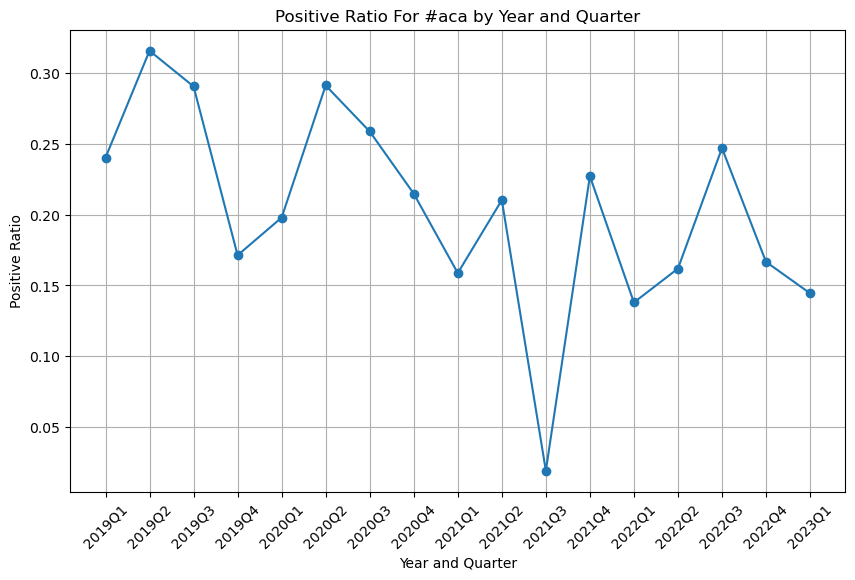

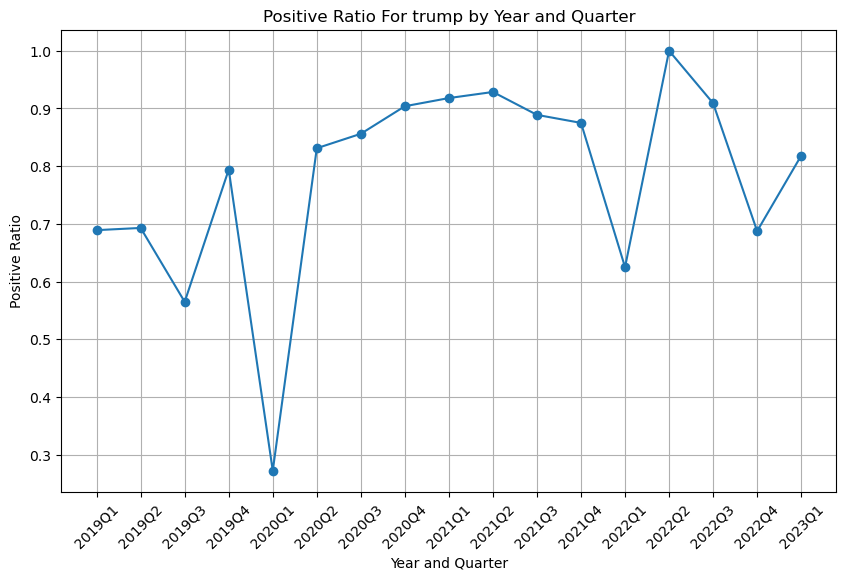

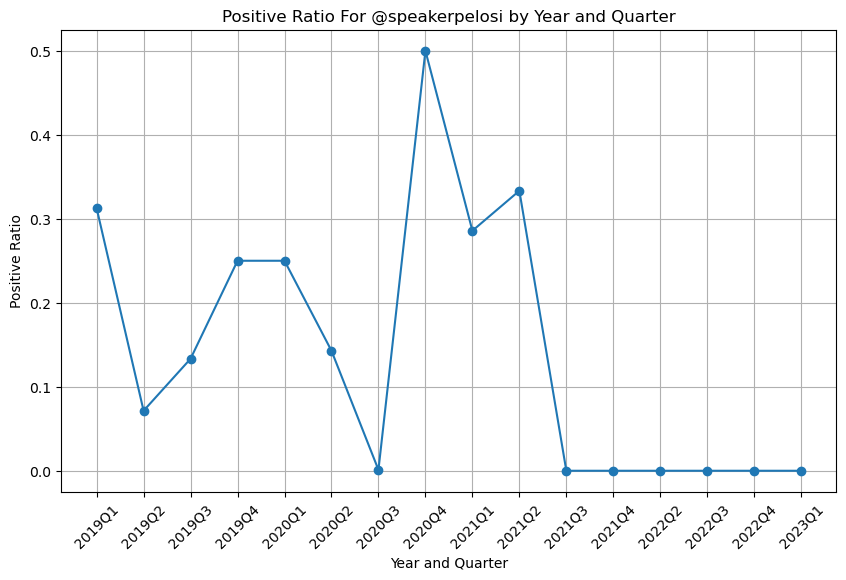

In [19]:
plot_word_ratio(twitter_df)
plot_word_ratio(twitter_df, '#obamacare') # High occurence of feature in positive and negative tweets
plot_word_ratio(twitter_df, '@realdonaldtrump') # High occurence of feature in positive
plot_word_ratio(twitter_df, 'obamacare') # High occurence of feature in positive and negative tweets
plot_word_ratio(twitter_df, '#aca') # High occurence of feature in positive and negative tweets
plot_word_ratio(twitter_df, 'trump') # High occurence of feature in positive
plot_word_ratio(twitter_df, '@speakerpelosi') # High occurence of feature in negative

5.2 Out of curiosity, we did furter analysis on the feature 'trump'. With Trump being a polarizing figure and with his stance on repleaing and replacing the ACA and his overall negativity towards it, it was surprizing to see that the 'trump' token appeard overwhelmingly in the positive classificatoin. We further explored below. 

In [20]:
trump = create_flag(twitter_df,'@realdonaldtrump')
postive_trump = trump.loc[(trump.loc[:,'Flag']==1) & (trump.loc[:,'Classification']==5),:].reset_index()

for text in postive_trump.loc[:,'Text'].head(5):
    print(text)


@realDonaldTrump So where is your healthcare plan?  The one that was going to be better and cheaper than Obamacare/ACA?  You talked a lot about it, but you never delivered.  You guys passed a tax cut for the rich and then left the rest of America one medical emergency away from financial ruin.
There is @BarackObama’s “Obama care” and then there is @realDonaldTrump’s “ I don’t care”. I’ll stick with the Obama care, thank you. #obamacare #ACA #2020Election #healthcare #StayAtHome
@overnighter5802 @Trixie66184127 @WarKamikaze @realDonaldTrump @FoxNews @QuinnipiacPoll 2 min search- u do senate

As VP
American Recovery Act
Economic Recovery Plan
Negotiated Budget Control Act
Led fed training program for 21 mil people w/$1.5 bill in grants
Got Shokin out of power
Helped get Obamacare/ACA passed
Launched Cancer initiative
 
Pence has done nothing
@realDonaldTrump Hey #Ohio Trump is fighting to REPEAL Obamacare(ACA)which would hurt access to addiction treatment for 220K people with opioid use 

In [21]:
negative_trump = trump.loc[(trump.loc[:,'Flag']==1) & (trump.loc[:,'Classification']==1),:].reset_index()

for text in negative_trump.loc[:,'Text'].head(5):
    print(text)

@realDonaldTrump I'm sorry Sir, but it did not end Obamacare/ACA. Many Americans with disabling pain conditions are still suffering due to the ACA starting a war on the pain community, Veterans &amp; anyone needing pain care.
I pray to God this war ends soon.
@charitypop1978 @realDonaldTrump He didn't end Obamacare/ACA and he didn't build the wall. He is leaving as he came in: sliding on a sea of lies.
@realDonaldTrump No, it didn't.

At all.

Obamacare/ACA is still with us, and it's more robust than ever.

You are a liar, and a bigot.
@realDonaldTrump https://t.co/WuEpweVtOC
@realDonaldTrump And you didn't replace Obamacare (ACA) as promised.  You will be remembered, as the biggest mistake America has ever made.





As mentioned in the report using business reviews to predict sentiment of a health care policy is limiting in accuracy. The limitation of the model can be attributed in our methodology, specifically the omition of neutral ratings from the star count. This provided a larger spectrum of extreme positive to neutral for a 5 star twitter rating and the same logic can be applied to the negative 1 star ratings. This can be seen above in the trump feature positive an negative tweets where the positive tweets read as neutral to negative and the negative tweets seem more extreme in negativity. 

Another limitation can be seen in the selection of  unigrams over a higher ngram which lost the ability to capture the context of words. This can be seen in our plots in the high variability in the positivty ratio for the selected features. One example, of the feature 'care' in the context of food can be things like "the server didnt care" or "I dont care for this resturant" which could potentially provide a negative wieght for the word 'care'. This would then provide a negative rating for the phrase "health care" which is one of the most common in the twitter data set and has no realtion to the context of 'care' in those hypothetical examples. 